# Mesa agent based model of farm/herd pathogen strain spread

* A Practical Introduction to Mechanistic Modeling of Disease Transmission in Veterinary Science. Kirkeby et al. Front. Vet. Sci., 26 January 2021 [link](https://www.frontiersin.org/articles/10.3389/fvets.2020.546651/full)
* Individual-based model for the control of Bovine Viral Diarrhea spread in livestock trade networks. Bassett et al. [link](https://doi.org/10.1016/j.jtbi.2021.110820)
* Representing Tuberculosis Transmission with Complex Contagion: An Agent-Based Simulation Modeling Approach. Zwick et al. Medical Decision Making April 27, 2021. [link](https://doi.org/10.1177/0272989X21100784)

In [1]:
import sys,os,random,time,string,itertools
import subprocess
import math
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('max_colwidth', 200)
import pylab as plt
import seaborn as sns
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import networkx as nx
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO, AlignIO
from IPython.display import display, HTML
import toyplot,toytree
import json

In [2]:
from btbabm import models
from btbabm import utils

In [3]:
import panel as pn
import panel.widgets as pnw
pn.extension('tabulator', css_files=[pn.io.resources.CSS_URLS['font-awesome']])

## Parameters

* mean_stay_time - mean time in a herd
* mean_inf_time - mean infection time
* cctrans - cow-cow transmission prob
* infected_start - time step infection starts
* seq_length - sequence length
* herd_class - type of herd

/home/farrell/.local/lib/python3.10/site-packages/geopandas/geoseries.py:660: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  result = super().apply(func, args=args, **kwargs)
/home/farrell/gitprojects/btbabm/btbabm/utils.py:245: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 350.38it/s]


model with 20 farms, 8 setts and 464 animals
mean inf time: 60 moves: False


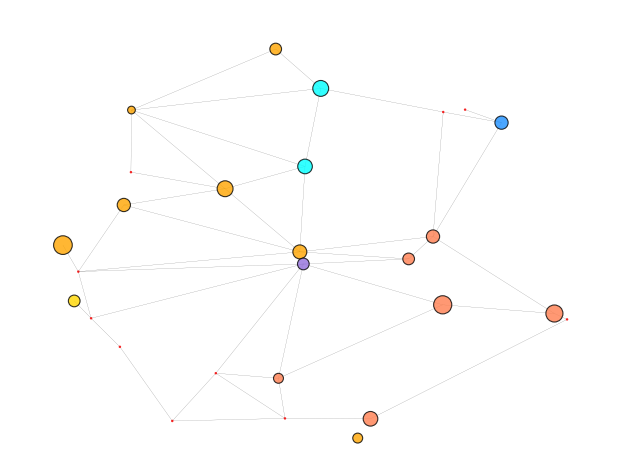

In [4]:
reload(models)
reload(utils)
model = models.FarmPathogenModel(F=20,C=400,S=8,seq_length=300)
#model = models.load_model('test.model')
model.run(500)
model.plot()
print (model)

In [ ]:
gdf, snpdist, meta = model.get_metadata()
utils.draw_tree('tree.newick')

## land parcels to network graph

- generate land parcels and then get network from it
- edges where parcels are close by
- weights for node distance

In [ ]:
farms = utils.generate_land_parcels(120,12,empty=0.8,seed=10,fragments=5) 
ax=farms.plot(color=farms.color,ec='.1',alpha=0.4,figsize=(8,8))
larg = farms.geometry.apply(utils.get_largest_poly)
cent = gpd.GeoDataFrame(data=farms.copy(),geometry=larg.geometry.centroid)
cent.plot(color=farms.color,markersize=100,ax=ax)

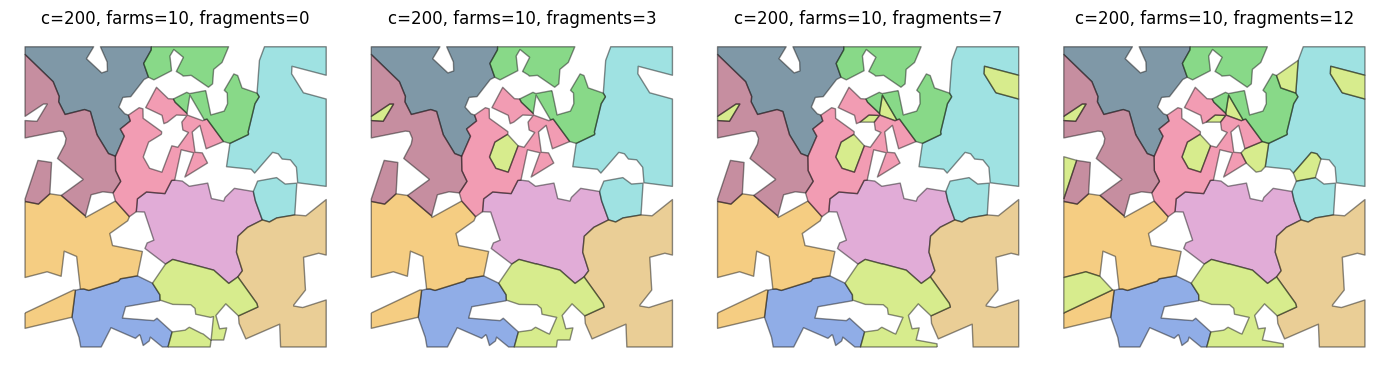

In [7]:
reload(utils)
from shapely.geometry import Point,MultiPoint,MultiPolygon,Polygon
fig,ax=plt.subplots(1,4,figsize=(14,5))
axs=ax.flat
i=0
c=200
f=10
#for c in np.arange(40,320,80):
#for e in [0,0.2,0.6,0.8]:
for frags in [0,3,7,12]:
    #f=int(c/8)
    farms = utils.generate_land_parcels(c,f,empty=0.3,seed=48,fragments=frags) 
    farms.plot(color=farms.color,ec='.1',alpha=0.5,ax=axs[i])#,legend=True)  #cmap='Paired'
    axs[i].set_title('c=%s, farms=%s, fragments=%s' %(c,f,frags))
    axs[i].axis('off')
    i+=1
plt.tight_layout()

18 herds in network


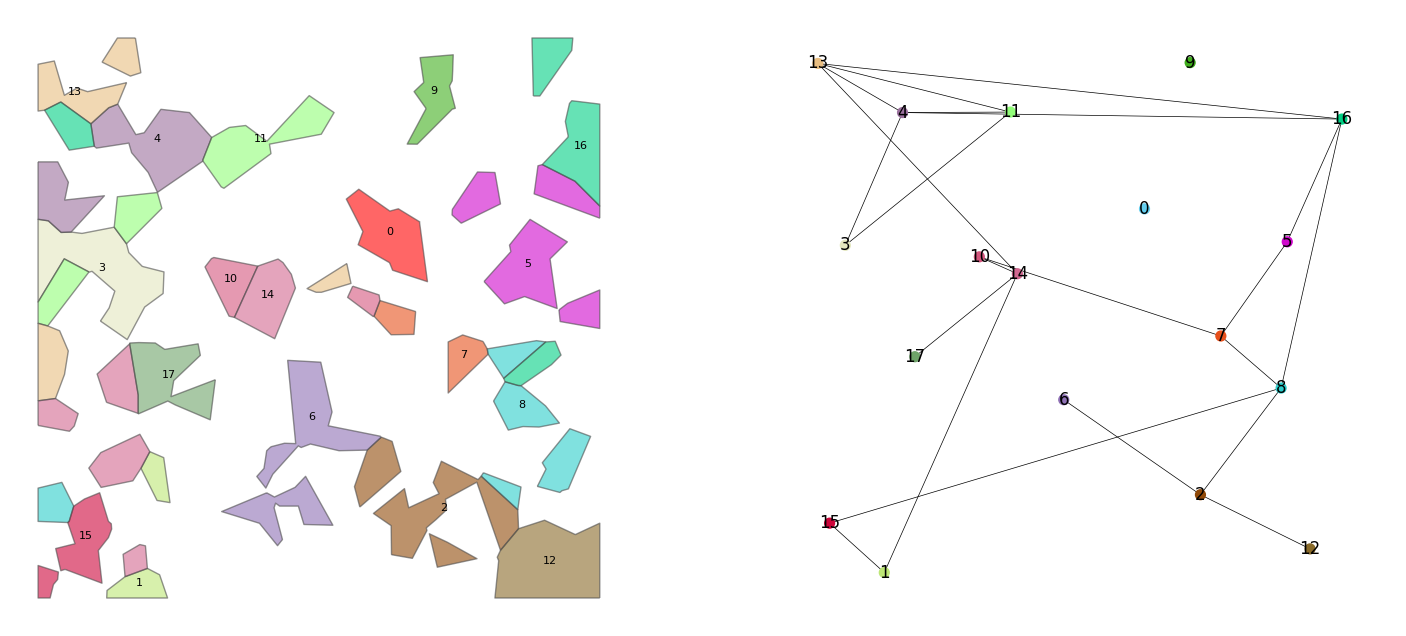

In [52]:
reload(utils)

farms = utils.generate_land_parcels(260,18,empty=.7,fragments=2,fragmented_farms=5,seed=5)
farms['loc_type'] = 'farm'
Glp,pos,cent = utils.land_parcels_to_graph(farms,dist=200,empty=.5,fragments=2,fragmented_farms=2,seed=8)

def plot_parcels_graph(parcels, cent, G, pos, labels=True):
    """Show parcels and associated graph"""
    
    fig,ax=plt.subplots(1,2,figsize=(18,8))
    parcels.loc[0,'color'] = 'red'
    parcels.plot(color=farms.color,ec='.3',alpha=0.6,ax=ax[0])
    for idx, row in cent.iterrows():
        ax[0].text(row.geometry.centroid.x, row.geometry.centroid.y,
                row['herd'], ha='center', fontsize=8)

    ax[0].axis('off')
    nx.draw(G,pos,node_size=50,width=0.5,ax=ax[1],node_color=cent.color,with_labels=True)
    weights = nx.get_edge_attributes(Glp, 'weight')
    #w=nx.draw_networkx_edge_labels(Glp, pos, weights, font_size=8, ax=axs[1])
    return

plot_parcels_graph(farms,cent,Glp,pos)
#farms

In [ ]:
G,pos = utils.geodataframe_to_graph(cent.sample(20), d=300, attrs=['loc_type','herd'])
weights = nx.get_edge_attributes(G, 'weight')
nx.draw(G,pos,node_size=50,alpha=0.4,edge_color='0.5')
w=nx.draw_networkx_edge_labels(G, pos, weights, font_size=8)

## test model

In [ ]:
reload(utils)
reload(models)

#model = models.FarmPathogenModel(F=125,S=5,C=1520,mean_inf_time=50,mean_stay_time=300,mean_latency_time=120,infected_start=4,allow_moves=False,
#                       cctrans=0.01,bctrans=0.1,seq_length=100,graph_seed=7)
model = models.FarmPathogenModel(graph=Glp,pos=pos,C=500,mean_inf_time=150,mean_stay_time=200,mean_latency_time=120,infected_start=5)
print (model)

fig,ax=plt.subplots(1,3,figsize=(14,5))
axs=ax.flat
st=time.time()
i=0

for s in range(1200):
    if s in [1,300,800]:
        utils.plot_grid(model,ax=axs[i],pos=model.pos,colorby='strain',ns='num_infected')
        axs[i].set_title(s)
        i+=1
    model.step()
#model.get_moves()
df=model.get_infected_data()
#print (df.species.value_counts())
#fig=plot_herds_data(model)
#fig,ax=plt.subplots(1,2,figsize=(15,4))
fig = utils.plot_by_species(model)
df=model.get_column_data()
df.plot()
#print (time.time()-st)

In [23]:
model.get_herds_data()

,id,loc_type,herd_class,size,infected,moves
0,0,farm,fattening,31,19,0
1,1,farm,beef suckler,33,20,0
2,2,farm,dairy,29,24,0
3,3,farm,beef,20,11,0
4,4,farm,fattening,33,19,0
5,5,farm,fattening,25,12,0
6,6,farm,beef suckler,25,15,0
7,7,farm,dairy,23,16,0
8,8,farm,beef,20,11,0
9,9,farm,beef suckler,38,20,0


## explore parameters

In [16]:
#fig,ax=plt.subplots(2,3,figsize=(15,7))
#axs=ax.flat
i=0
res = []
vals =  range(1,300,50)
for val in vals:
    #ax=axs[i]
    model = models.FarmPathogenModel(F=40,C=1200,S=5,mean_inf_time=val,mean_stay_time=360,mean_latency_time=150,
                           cctrans=0.01,bctrans=0.01,seq_length=100)                       
    for s in range(200):      
        model.step()
    df=model.get_infected_data()
    data = model.get_column_data()
    res.append(data.iloc[199])
    i+=1
    #data.plot(ax=ax)
    #ax.set_title(val)
#plt.tight_layout()

res = pd.DataFrame(res,index=vals)

In [ ]:
res.plot()

## dashboard

In [11]:
reload(utils)
reload(models)

def dashboard():
    
    def run_model(farms, animals, setts, cctrans, bctrans, staytime, inftime, latencytime, infstart, steps, delay, graph_type, graph_seed, refresh):

        def callback(x):
            str_pane.value += str(x)+'\n'

        model = models.FarmPathogenModel(farms, animals, setts, staytime, inftime, latencytime, cctrans, bctrans, infstart, False, 100, 
                              graph_type, graph_seed=graph_seed,
                              callback=callback)
        str_pane.value = ''
        callback(model)
        #fig1,ax1 = plt.subplots(1,1,figsize=(15,10))
        #grid_pane.object = fig1    
        fig2,ax2 = plt.subplots(1,1,figsize=(8,6))    
        plot_pane1.object = fig2
        fig3,ax3 = plt.subplots(1,1,figsize=(8,6))   
        plot_pane2.object = fig3
        progress.max=steps
        progress.value = 0 
          
        showsteps = list(range(1,steps+1,refresh))        
        #step through the model and plot at each step
        for i in range(1,steps+1):
            model.step()            
            plt.close()
            if i in showsteps:
                #ax1.clear()
                ns=nodesize_input.value
                y=model.year
                mov=len(model.get_moves())
                deaths=model.deaths
                total = len(model.get_animals())
                col = colorby_input.value
                text='day=%s year=%s moves=%s deaths=%s animals=%s' %(i,y,mov,deaths,total)
                #utils.plot_grid(model,ax=ax1,pos=model.pos,
                #          title=text, colorby=col, cmap=cmap_input.value,
                #          ns=ns, with_labels=labels_input.value)    
                p=utils.plot_grid_bokeh(model, title=text)
                grid_pane.object = p
                grid_pane.param.trigger('object')
                
                ax2.clear()        
                #s = model.circulating_strains()
                #d=model.get_infected_data()
                #df_pane.value = d
                hd = model.get_herds_data()
                df2_pane.value = hd
                #fig2 = utils.plot_inf_data(model)
                fig2 = utils.plot_by_species(model)
                plot_pane1.object = fig2                 
                plot_pane1.param.trigger('object')
                df = model.get_column_data()
                ax3.clear()
                df.plot(ax=ax3)
                ax3.set_xlim(0,steps)
                plot_pane2.param.trigger('object')
                html=html_tree(model)
                tree_pane.object = html
                out = model.G.nodes
                
            progress.value += 1
            time.sleep(delay)
        plt.clf()

    def html_tree(model):
        result = model.make_phylogeny(removed=True,redundant=False)
        if result==None:
            return '<p>no tree</p>'
        cl = model.get_clades('tree.newick')    
        idf = model.get_animal_data(removed=True)
        x=idf.merge(cl,left_on='id',right_on='SequenceName')
        x=x.set_index('SequenceName')
        x.index = x.index.map(str)
        tre=toytree.tree('tree.newick')
        col='strain'
        canvas = utils.draw_tree('tree.newick',x,col,tip_labels=False,width=500)
        toyplot.html.render(canvas, "temp.html")
        with open('temp.html', 'r') as f:
            html = f.read()
        return html
      
    def set_stop(event):
        global stop
        stop = True
        print ('STOP')
  
    graph_types = ['default','watts_strogatz','erdos_renyi','barabasi_albert','powerlaw_cluster','random_geometric']
    farm_types = ['mixed','beef','dairy','suckler']
    cmaps = ['Blues','Reds','Greens','RdBu','coolwarm','summer','winter','icefire','hot','viridis']
    #grid_pane = pn.pane.Matplotlib(plt.Figure(),tight=True,width=900,height=620)
    grid_pane = pn.pane.Bokeh(width=800)
    plot_pane1 = pn.pane.Matplotlib(plt.Figure(),height=300)
    plot_pane2 = pn.pane.Matplotlib(plt.Figure(),height=300)
    tree_pane = pn.pane.HTML()
    str_pane = pnw.TextAreaInput(disabled=True,height=600,width=400) 
    df_pane = pnw.Tabulator(show_index=False,disabled=True,height=600)
    df2_pane = pnw.Tabulator(show_index=False,disabled=True,height=600)
    
    w=140
    colorby = ['num_infected','perc_infected','herd_size','loc_type','herd_class','strain']
    go_btn = pnw.Button(name='run',width=w,button_type='success')
    stop_btn = pnw.Button(name='stop',width=w,button_type='danger')
    farms_input = pnw.IntSlider(name='farms',value=20,start=5,end=1000,step=1,width=w)
    animals_input = pnw.IntSlider(name='cows',value=400,start=10,end=5000,step=10,width=w)
    setts_input = pnw.IntSlider(name='setts',value=5,start=1,end=100,step=1,width=w)
    farmtypes_input = pnw.Select(name='farm types',options=farm_types,width=w)
    cctrans_input = pnw.FloatSlider(name='CC trans',value=1,step=.1,start=0,end=5,width=w)
    bctrans_input = pnw.FloatSlider(name='BC trans',value=1,step=.1,start=0,end=5,width=w)
    staytime_input = pnw.FloatSlider(name='mean stay time',value=100,step=1,start=5,end=1000,width=w)
    inftime_input = pnw.FloatSlider(name='mean inf. time',value=60,step=1,start=5,end=600,width=w)
    latencytime_input = pnw.FloatSlider(name='mean latency time',value=100,step=1,start=10,end=600,width=w)
    infstart_input = pnw.FloatSlider(name='start infected',value=5,step=1,start=1,end=500,width=w)
    steps_input = pnw.IntSlider(name='steps',value=10,start=1,end=2000,width=w)
    refresh_input = pnw.IntSlider(name='refresh rate',value=1,start=1,end=100,width=w)
    delay_input = pnw.FloatSlider(name='step delay',value=0,start=0,end=3,step=.2,width=w)
    graph_input = pnw.Select(name='graph type',options=graph_types,width=w)
    graph_seed_input = pnw.IntInput(name='graph seed',value=10,width=w)
    #seed_input = pnw.Select(name='graph seed',options=['random'],width=w)
    colorby_input = pnw.Select(name='color by',options=colorby,width=w)
    colorby_input.value = 'strain'
    cmap_input = pnw.Select(name='colormap',options=cmaps,width=w)
    nodesize_input = pnw.Select(name='node size',value='herd_size',options=colorby[:3],width=w)
    labels_input = pnw.Checkbox(name='node labels',value=False,width=w)
    progress = pn.indicators.Progress(name='Progress', value=0, width=600, bar_color='primary')
    
    widgets = pn.Column(pn.Tabs(('model',pn.WidgetBox(farms_input,animals_input,setts_input,farmtypes_input,cctrans_input,bctrans_input,
                                                      staytime_input,inftime_input,latencytime_input,infstart_input,steps_input,refresh_input,delay_input)), 
                                ('options',pn.WidgetBox(graph_input,graph_seed_input,colorby_input,cmap_input,nodesize_input,labels_input))), width=w+30)
    #widgets = pn.Column(go_btn)
    
    def execute(event):
        #run the model with widget 
        run_model(farms_input.value, animals_input.value, setts_input.value, cctrans_input.value/100, bctrans_input.value/100, 
                  staytime_input.value, inftime_input.value, latencytime_input.value, infstart_input.value,
                  steps_input.value, delay_input.value,graph_input.value, graph_seed_input.value, refresh_input.value)

    go_btn.param.watch(execute, 'clicks')
    
    app = pn.Column(pn.Row(go_btn,progress),
                pn.Row(widgets,grid_pane,
                 pn.Tabs(('plots',pn.Column(plot_pane1,plot_pane2)), ('tree',tree_pane), ('inf_data',df_pane), ('herd_data',df2_pane), ('debug',str_pane)),
                 sizing_mode='stretch_both',background='WhiteSmoke'))

    return app

In [ ]:
dashboard()

In [13]:
def diffseqs(seq1,seq2):
    """Diff two sequences"""

    c=0
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            c+=1
    return c

def diffseqs2(seq1, seq2):
    """Diff two sequences"""

    return sum(a != b for a, b in zip(seq1, seq2))


s1='ATTGCGGGAGAGGTTTTTAAAAATTCTGCGGGATACGTTTTTAAAAAGGAGAGGTTTTTAAAAATTCTGCGGGATACGTTTTTAAAAA'
s2='ATTTCGGGCGAGTTTCTTAATAATAATGCGGGATAAGTTATTTAATAGGAGAGGTTTTTAAAAATTCTGCGGGATACGTTTTTAAAAA'
%timeit diffseqs2(s1,s2)

4.24 µs ± 88.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## extract relevant metrics for regression model testing

- use simulated land parcels so we can get lp network

In [89]:
reload(models)
reload(utils)
farms = utils.generate_land_parcels(1000,300,empty=.5,fragments=2,fragmented_farms=10,seed=3)
Glp,pos,cent = utils.land_parcels_to_graph(farms,dist=100,empty=.5,fragments=2,fragmented_farms=2,seed=8)

mymodel=models.FarmPathogenModel(C=2000,graph=Glp,pos=pos,seq_length=200,infected_start=40,
                               mean_inf_time=50,mean_stay_time=360,mean_latency_time=180,allow_moves=False)
#mymodel=models.FarmPathogenModel(60,1000,5,graph_seed=6,seq_length=100,infected_start=50,
#                               mean_inf_time=80,mean_stay_time=360,mean_latency_time=120,allow_moves=False,
#                               graph_type='default')
print (mymodel)

257 herds in network
model with 257 farms, 0 setts and 2000 animals
CC rate:0.01 BC rate:0.001


In [43]:
mymodel = models.load_model('test.model')

In [44]:
mymodel.run(600)
print (mymodel)
#mymodel.save('test.model')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 82.75it/s]

model with 257 farms, 0 setts and 2000 animals
CC rate:0.01 BC rate:0.001


In [ ]:
#plot_parcels_graph(farms, Glp, pos)
#f,ax=plt.subplots(1,1)
#utils.plot_grid(mymodel,ax=ax,pos=mymodel.pos,colorby='strain',ns='num_infected')
plot_parcels_graph(farms, Glp, pos)

<Axes: xlabel='Step'>

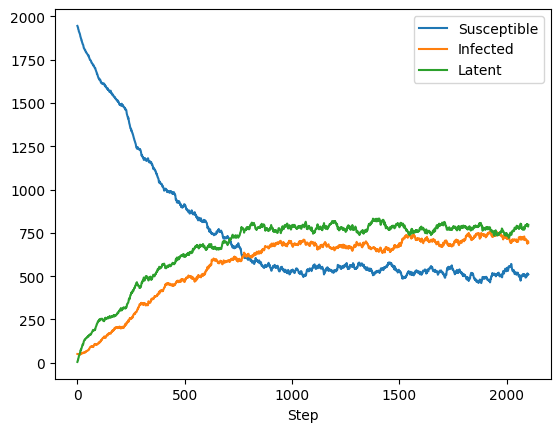

In [99]:
df = mymodel.get_column_data()
df.plot()

In [100]:
gdf,snpdist,meta = mymodel.get_metadata()

#save meta stuff
gdf.to_file('cent.shp.zip')
snpdist.to_csv('snpdist.csv')
meta.to_csv('meta.csv',index=False)

In [58]:
cl = mymodel.get_clades('tree.newick')
len(cl)

<<class 'Bio.Align.MultipleSeqAlignment'> instance (492 records of length 187) at 7ff11f07c610>

In [101]:
reload(utils)
x=meta.set_index('SequenceName')
#x=cl.set_index('SequenceName')
x.index = x.index.map(str)

col='strain'
canvas = utils.draw_tree('tree.newick',x,col,tip_labels=False,width=500)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="500.0px" viewBox="0 0 500.0 500.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t9b558825712f4cbd877812314196ea7f"> <g fill="rgb(70.2%,64.3%,14.9%)" fill-opaci

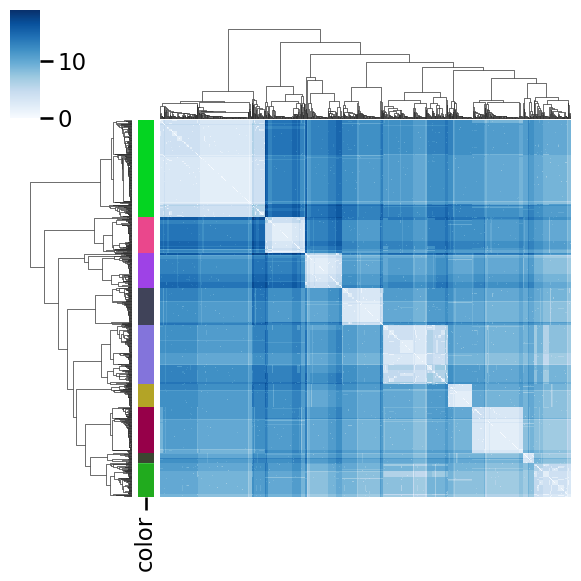

In [162]:
cg = sns.clustermap(snpdist, cmap='Blues', row_colors=x.color,xticklabels=False,yticklabels=False,figsize=(6,6))
cm=dict(zip(x['strain'],x.color))
#p=plotting.make_legend(cg.fig, cm, loc=(1.1, .6), title='strain',fontsize=10)

In [ ]:
gdf=gdf.merge(cl,left_on='id',right_on='SequenceName')
print (len(gdf))
gdf['geometry'] = gdf.apply(lambda x: utils.jitter_points(x,6),1)
gdf.plot(column='strain',s=12,alpha=0.6,cmap='Paired',figsize=(7,7))#,legend=True)

In [ ]:
def distance_matrix(aln):
    """
    Calculate the distance matrix for a DataFrame of letter codes
    with samples in rows and features in columns.
    """
    # Convert the DataFrame to a NumPy array
   
    data = np.array([list(rec) for rec in aln], 'S1')
    # Calculate the pairwise distances between rows
    dist_matrix = np.sqrt(((data[:, None, :] - data) ** 2).sum(-1))

    return pd.DataFrame(dist_matrix, index=df.index, columns=df.index)

aln=mymodel.aln
distance_matrix(aln)


## epi metrics regression testing

In [102]:
from btbabm import epi_regression

In [152]:
sns.set_context('talk')

In [ ]:
reload(epi_regression)
for s in [200,400]:
    X,y = epi_regression.test(snp_cutoff=25, subsample=s)

In [ ]:
X['y'] = y
df=X.sample(500)
df.plot('y','SampleTimeDist',alpha=0.1,kind='scatter')

In [ ]:
reload(epi_regression)
grid_result = epi_regression.parameter_test()

In [63]:
grid_result.best_params_

{'max_depth': 6, 'n_estimators': 500}

## basic movements, test get_moves

In [ ]:
reload(models)
reload(utils)
model = models.FarmPathogenModel(F=20,C=500,seq_length=300,allow_moves=True, mean_stay_time=50)
model.run(50)
model.plot()
print (model)
model.get_moves(birth=False)

## moves data - large movement history simulation

In [10]:
reload(models)
#movesmodel = models.FarmPathogenModel(1000,20000,5,mean_stay_time=100,graph_seed=5,seq_length=100,allow_moves=True)
movesmodel = models.load_model('movestest.model')
print (movesmodel)

model with 1000 farms, 5 setts and 20038 animals
CC rate:0.01 BC rate:0.001


In [14]:
movesmodel.run(1000)
movesmodel.save('movestest.model')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:34<00:00,  2.99it/s]


In [16]:
movedata = movesmodel.get_moves(removed=True)
#movedata.id.value_counts().hist()
movedata.to_csv('movestest.csv')

In [ ]:
#fig,ax=plt.subplots(1,1,figsize=(20,10))
#utils.plot_grid(movesmodel,ax=ax,colorby='strain',ns='num_infected')
p=utils.plot_grid_bokeh(movesmodel)
pn.pane.Bokeh(p)